# Taller 1
## Preguna 1: Construye funciones que realicen todo el proceso que involucra la metodología de Box-Jenkins. 

(i) Presenta el pseudo-código con todo el flujo de programación asociado a la función que estás diseñando.
Identifica claramente cuáles son los inputs requeridos por parte del usuario y el paso a paso de la aplicación
de la metodología de Box-Jenkins.

(ii) Construye una función en el lenguaje de tu preferencia. Esta función, como mínimo, debe:
1. Presentar un gráfico de la serie que se está analizando.
2. Construir y presentar gráficos de la ACF y la PACF.
3. Calcular y presentar los criterios de información AIC y SBC. Ten en cuenta que la fórmula específica
dependerá del método que utilices para estimar el modelo.

Gráfico de la serie:

In [ ]:
# Working directory:
setwd("C:\\Users\\slbrb\\Desktop\\Universidades\\USFQ\\TeachingAssistant\\202420\\Macro Avanzada\\Talleres\\T1\\data\\serie1")

# Load the data
my_data <- read.csv("serie1_G1.csv", header = TRUE)

# Plot the data
plot(my_data, type = "l", col = "blue", lwd = 2, xlab = "Time", ylab = "Value", main = "Time series data")

install.packages("gridExtra")


# Cálculo de ACF y PACF

## 1. Definiciones básicas

Dada una serie temporal $y_t$ con $t = 1,2, \dots, n$, definimos los siguientes términos:

- **Media muestral**:  
  $$ \bar{y} = \frac{1}{n} \sum_{t=1}^{n} y_t $$

- **Varianza muestral**:  
  $$ \sigma^2 = \frac{1}{n} \sum_{t=1}^{n} (y_t - \bar{y})^2 $$

- **Covarianza muestral entre $y_t$ y $y_{t-k}$**:  
  $$ \gamma_k = \frac{1}{n} \sum_{t=k+1}^{n} (y_t - \bar{y})(y_{t-k} - \bar{y}) $$

## 2. Autocorrelación (ACF)

La función de autocorrelación de un proceso estocástico se define como:

- **Autocorrelación en el rezago $s$**:  
  $$ r_s = \frac{\sum_{t=s+1}^{T} (y_t - \bar{y})(y_{t-s} - \bar{y})}{\sum_{t=1}^{T} (y_t - \bar{y})^2} $$

Donde:
- $ y_t $ es la serie de tiempo.
- $ \bar{y} $ es la media muestral.
- $ s $ es el número de rezagos.

La **ACF** se calcula de manera manual hasta el rezago **máximo de $T/4$**.

### 2.1 Intervalos de Confianza para la ACF según Box & Jenkins

Bajo la hipótesis nula de que $y_t$ sigue un **proceso MA(s-1)**, la varianza de la autocorrelación muestral $r_s$ se calcula como:

- Para $s = 1$:  
  $$ \text{Var}(r_1) = \frac{1}{T} $$

- Para $s > 1$:  
  $$ \text{Var}(r_s) = \frac{1}{T} \left( 1 + 2 \sum_{j=1}^{s-1} r_j^2 \right) $$

Si asumimos normalidad, la ACF es significativa si $ |r_s| > 2 \times \text{sd}(r_s) $.

## 3. Autocorrelación Parcial (PACF)

La función de autocorrelación parcial mide la correlación directa entre $y_t$ y $y_{t-k}$, eliminando la influencia de los rezagos intermedios.

Para calcular la **PACF**:

1. **Primeros valores base**:
   - Para $ s = 1 $:  
     $$ \phi_{11} = r_1 $$
   - Para $ s = 2 $:  
     $$ \phi_{22} = \frac{r_2 - r_1^2}{1 - r_1^2} $$

2. **Para $ s \geq 3 $**:  
   $$
   \phi_{ss} = \frac{r_s - \sum_{j=1}^{s-1} \phi_{s-1,j} r_{s-j}}{1 - \sum_{j=1}^{s-1} \phi_{s-1,j} r_j}
   $$

   Y los coeficientes intermedios se actualizan con:  
   $$
   \phi_{sj} = \phi_{s-1,j} - \phi_{ss} \phi_{s-1,s-j}, \quad j = 1, 2, \dots, s-1
   $$


### 3.1 Intervalos de Confianza para la PACF según Box & Jenkins

Bajo la hipótesis nula de que el proceso sigue un **modelo AR(p)**, la varianza de los coeficientes estimados de la PACF es:

  $$ \text{Var}(\hat{\phi}_{p+i,p+i}) \approx \frac{1}{T} $$

Si asumimos normalidad, la PACF es significativa si $ |\hat{\phi}_{p+i,p+i}| > 2 / \sqrt{T} $.

## 4. Número Máximo de Rezagos y Visualización

Según Enders (Capítulo 2), el número máximo de rezagos analizados se define como:

  $ \text{Max Lag} = \frac{T}{4} $

En los gráficos:
- **Rezagos significativos** se resaltan en **rojo**.
- **Intervalos de confianza** se muestran con **líneas de referencia**.


In [ ]:
# Función para calcular la ACF y PACF y compararla con las funciones de R
acf_pacf_manual <- function(series) {
    library(ggplot2)
    library(gridExtra)
    library(dplyr)
    library(tidyr)

    # Convertir a vector numérico en caso de que sea data.frame o lista
    if (is.data.frame(series)) {
        series <- as.numeric(series[[2]]) # Selecciona la columna con datos
    } else {
        series <- as.numeric(series) # Convierte cualquier otro formato a numérico
    }

    T <- length(series)
    max_lag <- floor(T / 4) # Número máximo de rezagos a calcular

    # Cálculo media
    mean_y <- mean(series)

    # Cálculo varianza
    var_y <- var(series)

    # Cálculo manual de la ACF
    acf_values <- numeric(max_lag)
    for (s in 1:max_lag) {
        numerator <- sum((series[(s + 1):T] - mean_y) * (series[1:(T - s)] - mean_y))
        denominator <- sum((series - mean_y)^2)
        acf_values[s] <- numerator / denominator
    }

    # Cálculo de los intervalos de confianza para la ACF
    acf_var <- numeric(max_lag)
    acf_var[1] <- 1 / T # Para s = 1
    for (s in 2:max_lag) {
        acf_var[s] <- (1 / T) * (1 + 2 * sum(acf_values[1:(s - 1)]^2))
    }
    acf_sd <- sqrt(acf_var)
    acf_threshold_value <- min(acf_sd[-1]) * 2

    # Identificar rezagos significativos para la ACF
    significant_acf_lags <- which(abs(acf_values) > acf_threshold_value)

    # Cálculo manual de la PACF 
    pacf_values <- numeric(max_lag)
    phi <- matrix(0, nrow = max_lag, ncol = max_lag) # Matriz de coeficientes parciales

    # Caso base: el primer coeficiente PACF es la primera ACF
    pacf_values[1] <- acf_values[1]
    phi[1, 1] <- acf_values[1]

    pacf_values[1] <- acf_values[1] # Caso base
    phi[1, 1] <- acf_values[1]

    for (s in 2:max_lag) {
        if (s == 2) {
            phi[s, s] <- (acf_values[s] - acf_values[1]^2) / (1 - acf_values[1]^2)
        } else {
            sum_num <- sum(phi[s - 1, 1:(s - 1)] * acf_values[rev(1:(s - 1))])
            sum_den <- sum(phi[s - 1, 1:(s - 1)] * acf_values[1:(s - 1)])
            phi[s, s] <- (acf_values[s] - sum_num) / (1 - sum_den)
        }

        for (j in 1:(s - 1)) {
            phi[s, j] <- phi[s - 1, j] - phi[s, s] * phi[s - 1, s - j]
        }

        pacf_values[s] <- phi[s, s]
    }

    # Intervalos de confianza para la PACF, 95% de confianza
    pacf_threshold <- 2 / T 

    # Identificar rezagos significativos para la PACF
    significant_pacf_lags <- which(abs(pacf_values) > pacf_threshold)

    # Comparación con funciones de R
    acf_r <- acf(series, lag.max = max_lag + 1, plot = FALSE)$acf[-1]
    pacf_r <- pacf(series, lag.max = max_lag + 1, plot = FALSE)$acf

    # Definir el tamaño mínimo entre los cálculos manuales y las funciones de R
    common_lag <- min(length(acf_values), length(acf_r), length(pacf_values), length(pacf_r))

    # Ajustar el tamaño de los vectores para que coincidan
    acf_values <- acf_values[1:common_lag]
    pacf_values <- pacf_values[1:common_lag]
    acf_r <- acf_r[1:common_lag]
    pacf_r <- pacf_r[1:common_lag]

    # Crear la tabla de comparación con los valores ajustados
    comparison_table <- data.frame(
        Lag = 1:common_lag,
        ACF_Manual = round(acf_values, 4),
        ACF_R = round(acf_r, 4),
        PACF_Manual = round(pacf_values, 4),
        PACF_R = round(pacf_r, 4)
    )

    print(comparison_table, row.names = FALSE, quote = FALSE)

    # Función para graficar la comparación
    plot_comparison <- function(manual_values, r_values, title) {
        df <- data.frame(Lag = 1:max_lag, Manual = manual_values, R_Function = r_values)

        ggplot(df, aes(x = Lag)) +
            geom_line(aes(y = Manual, color = "Manual"), size = 1) +
            geom_line(aes(y = R_Function, color = "R Function"), size = 1, linetype = "dashed") +
            theme_minimal() +
            labs(title = title, x = "Rezago", y = "Valor") +
            theme(plot.title = element_text(hjust = 0.5))
    }

    # Crear gráficos de comparación
    plot_acf_comparison <- plot_comparison(acf_values, acf_r, "Comparación ACF")
    plot_pacf_comparison <- plot_comparison(pacf_values, pacf_r, "Comparación PACF")

    # Ajustar tamaño del gráfico
    options(repr.plot.width = 16, repr.plot.height = 8)

    # Mostrar gráficos comparativos
    grid.arrange(plot_acf_comparison, plot_pacf_comparison, ncol = 2)

    # Graficar la ACF
    acf_plot <- ggplot(data.frame(Lag = 1:max_lag, ACF = acf_values), aes(x = Lag, y = ACF)) +
        geom_bar(stat = "identity", fill = "blue", color = "black") +
        geom_hline(yintercept = c(-acf_threshold_value, acf_threshold_value), linetype = "dashed", color = "red") +
        theme_minimal() +
        labs(title = "Función de Autocorrelación (ACF)", x = "Rezago", y = "ACF") +
        theme(plot.title = element_text(hjust = 0.5))

    # Graficar la PACF
    pacf_plot <- ggplot(data.frame(Lag = 1:max_lag, PACF = pacf_values), aes(x = Lag, y = PACF)) +
        geom_bar(stat = "identity", fill = "green", color = "black") +
        geom_hline(yintercept = c(-pacf_threshold, pacf_threshold), linetype = "dashed", color = "red") +
        theme_minimal() +
        labs(title = "Función de Autocorrelación Parcial (PACF)", x = "Rezago", y = "PACF") +
        theme(plot.title = element_text(hjust = 0.5))

    grid.arrange(acf_plot, pacf_plot, ncol = 2)

    return(list(
        ACF_Manual = acf_values,
        PACF_Manual = pacf_values,
        ACF_R = acf_r,
        PACF_R = pacf_r,
        Comparison_Table = comparison_table
    ))
}

 Lag ACF_Manual   ACF_R PACF_Manual  PACF_R
   1     0.1309  0.1309      0.1309  0.1309
   2     0.0487  0.0487      0.0321  0.0321
   3    -0.0184 -0.0184     -0.0293 -0.0293
   4     0.0616  0.0616      0.0673  0.0673
   5     0.0684  0.0684      0.0554  0.0554
   6     0.1106  0.1106      0.0913  0.0913
   7     0.1679  0.1679      0.1467  0.1467
   8     0.1595  0.1595      0.1229  0.1229
   9     0.1225  0.1225      0.0898  0.0898
  10     0.0221  0.0221     -0.0069 -0.0069
  11     0.0892  0.0892      0.0738  0.0738
  12    -0.1380 -0.1380     -0.1974 -0.1974
  13     0.0852  0.0852      0.0686  0.0686
  14     0.2056  0.2056      0.1615  0.1615
  15     0.1153  0.1153     -0.0033 -0.0033
  16     0.0936  0.0936      0.0543  0.0543
  17     0.0595  0.0595      0.0361  0.0361
  18     0.0470  0.0470      0.0114  0.0114
  19     0.0144  0.0144      0.0041  0.0041
  20    -0.1405 -0.1405     -0.1973 -0.1973
  21    -0.0078 -0.0078     -0.0328 -0.0328
  22    -0.0082 -0.0082     -0.1

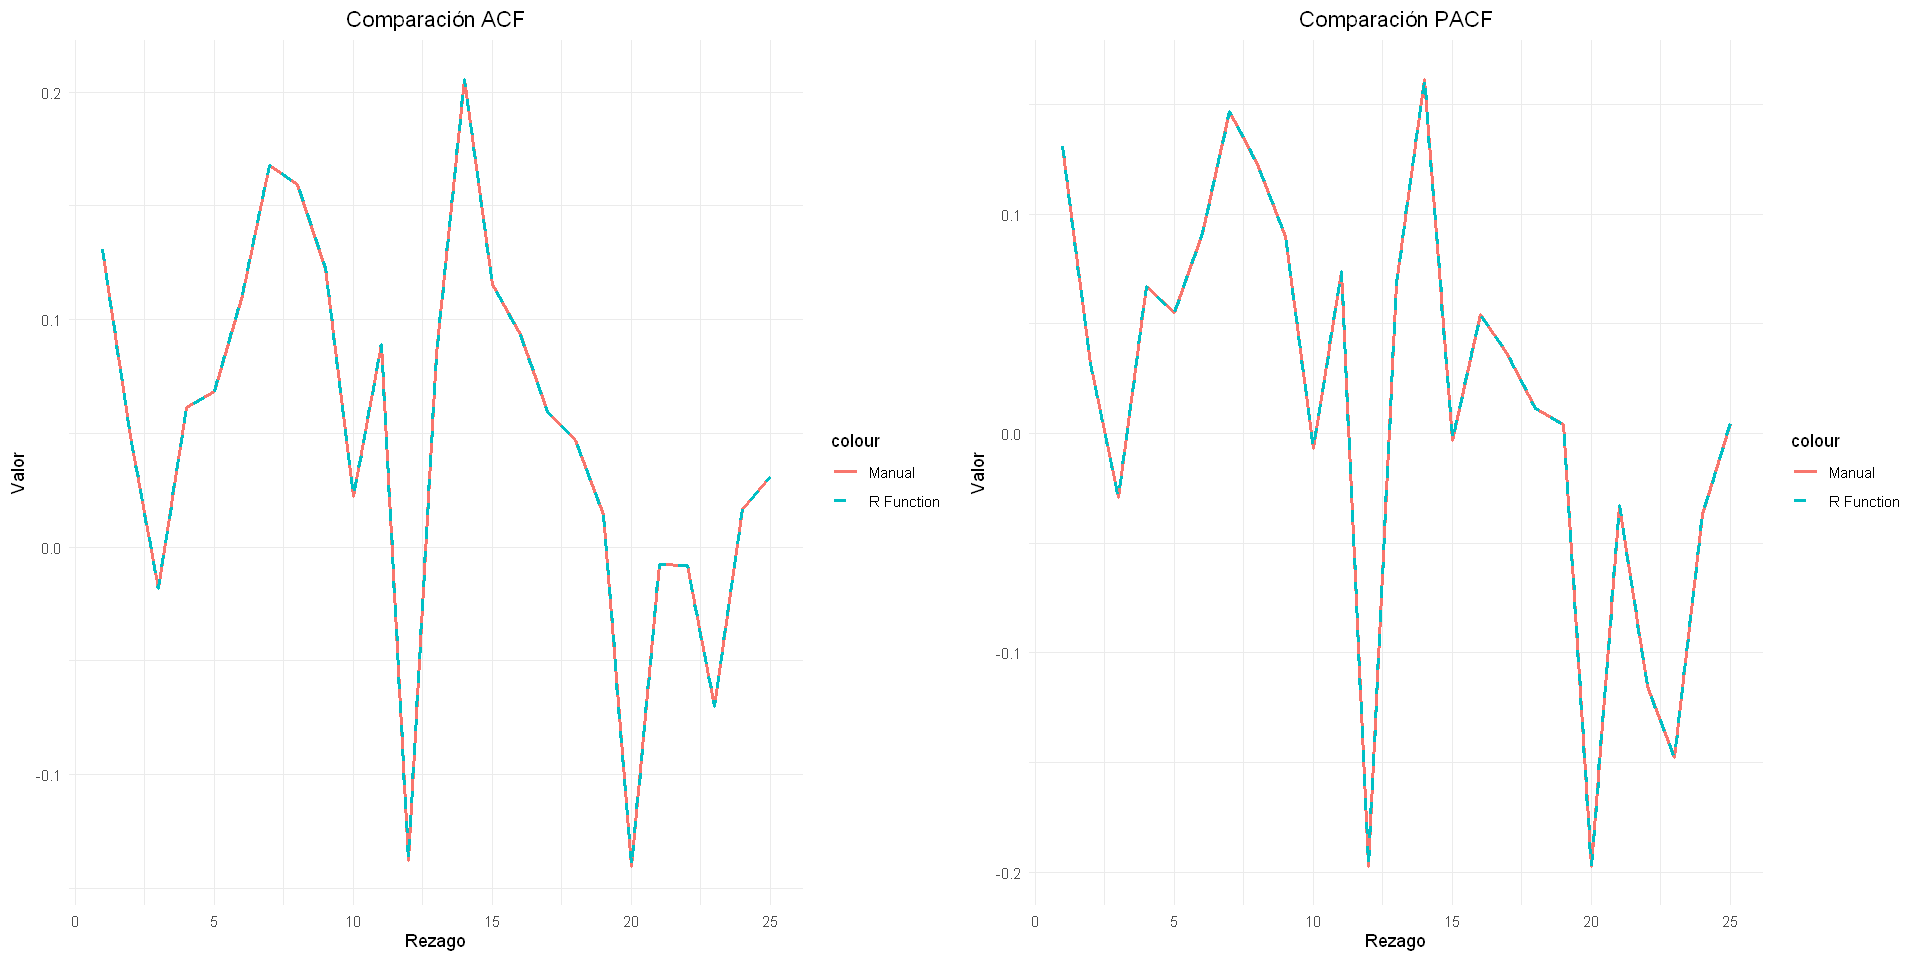

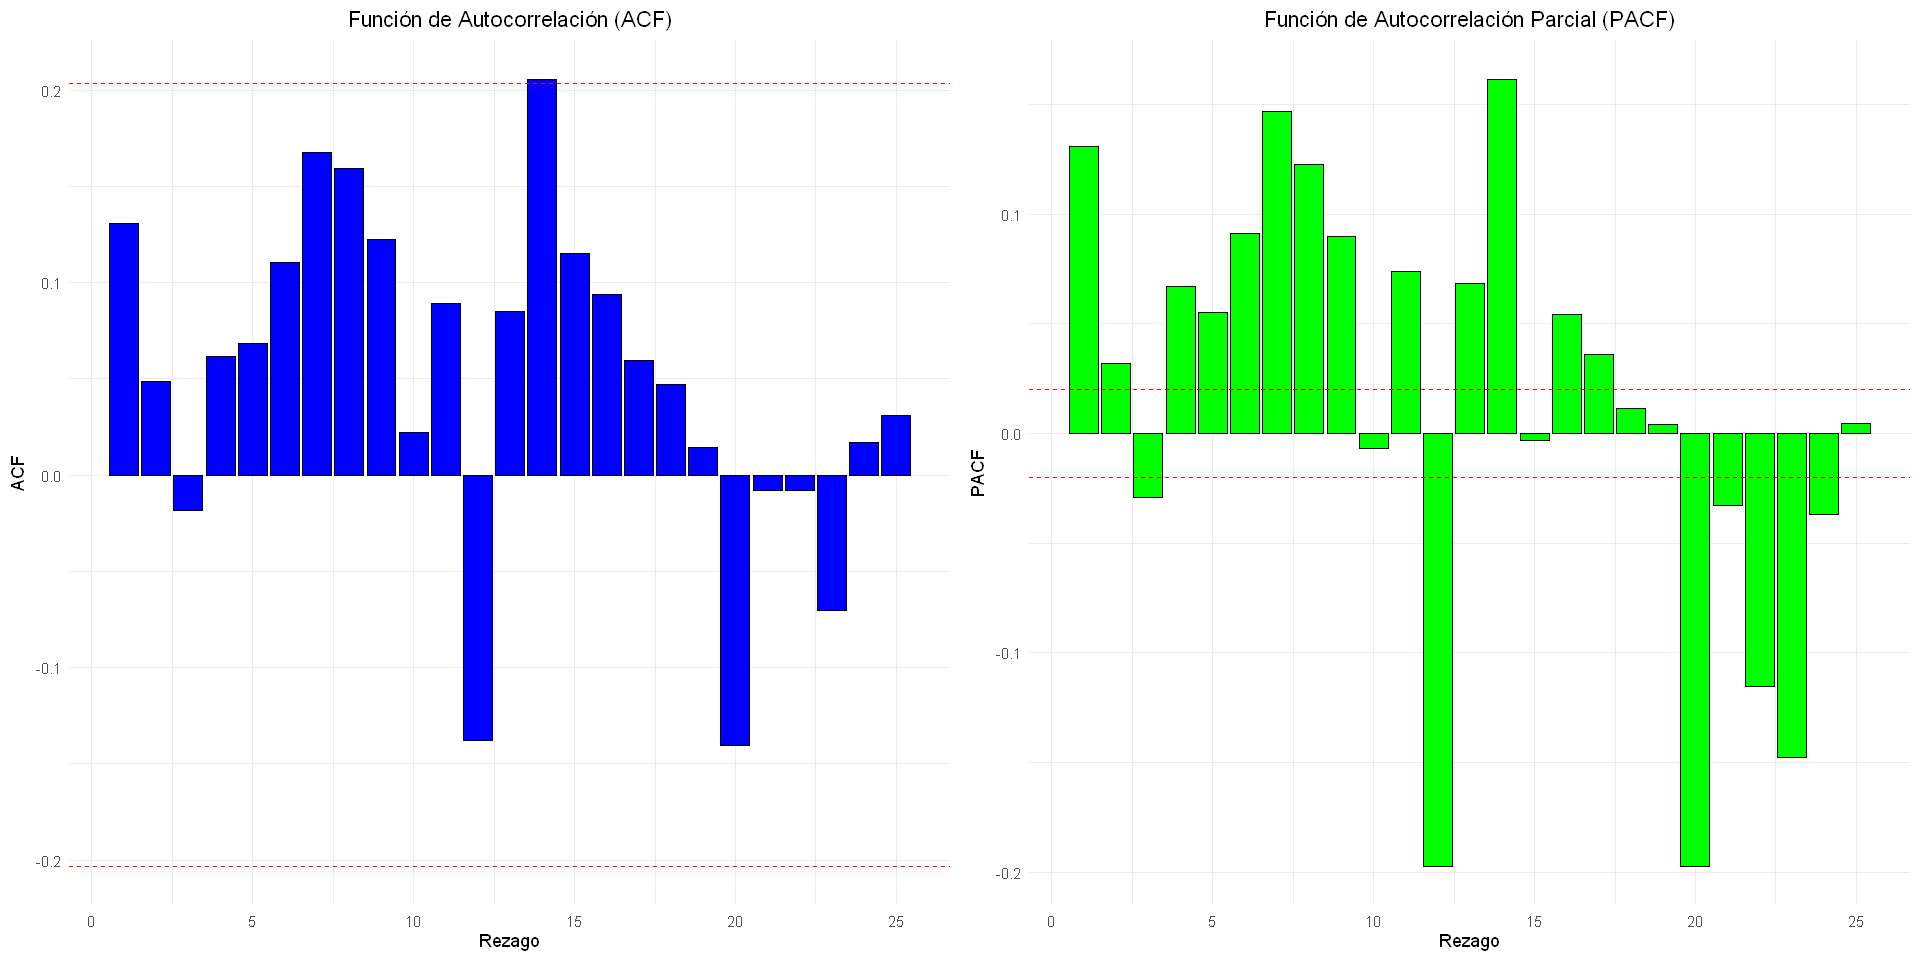

In [74]:
# Usar la función para calcular la ACF y PACF
results <- acf_pacf_manual(my_data$y)